# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [79]:
# Import necessary libraries
import pandas as pd

import holidays
import statsmodels.api as sm
import warnings
import itertools
from sklearn.model_selection import train_test_split

from Data.load_data import get_energy_data
from helper_functions import create_error_metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Model Selection

[Discuss the type(s) of models you consider for this task, and justify the selection.]



## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [80]:
german_holidays = holidays.country_holidays("Germany", years=[2017, 2018, 2019],
                                            subdiv="BY") + holidays.country_holidays("Germany",
                                                                                     years=[2017, 2018, 2019],
                                                                                     subdiv="SH")

In [81]:
def create_dummy_variables(prefix: str, df_total_temp: pd.DataFrame, df_temp: pd.DataFrame, drop_first=True) -> pd.DataFrame:
    df_dummies = pd.get_dummies(df_temp, prefix=prefix, drop_first=drop_first)
    df_dummies.index = df_total_temp.index
    return df_dummies

In [98]:
df = get_energy_data()
df = pd.concat([
    df,
    create_dummy_variables("hour", df, df.index.hour),
    create_dummy_variables("dayofweek", df, df.index.dayofweek),
    create_dummy_variables("month", df, df.index.month),
    # create_dummy_variables("dayofyear", df, df.index.dayofyear),
    create_dummy_variables("weekday", df, df.index.weekday),
    create_dummy_variables("isweekend", df, df.index.weekday // 5),
    create_dummy_variables("isHoliday", df, pd.DataFrame(
        ["non-holiday" if x not in german_holidays else  for x in df.index.date]), False).drop("non-holiday")
], axis=1)
df

,Load,Temperature,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,isHoliday_Easter Monday,isHoliday_Epiphany,isHoliday_German Unity Day,isHoliday_Good Friday,isHoliday_Labor Day,isHoliday_New Year's Day,isHoliday_Reformation Day,isHoliday_Second Day of Christmas,isHoliday_Whit Monday,isHoliday_non-holiday
Date (UTC),,,,,,,,,,,,,,,,,,,,,
2016-12-31 23:00:00+00:00,188528.8,-2.2,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2017-01-01 00:00:00+00:00,183256.4,-2.4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2017-01-01 01:00:00+00:00,177785.3,-2.5,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2017-01-01 02:00:00+00:00,172906.9,-2.7,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2017-01-01 03:00:00+00:00,169715.8,-2.8,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 18:00:00+00:00,208132.8,1.8,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2019-12-31 19:00:00+00:00,195995.3,1.4,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2019-12-31 20:00:00+00:00,188942.4,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [95]:
X = df.loc[:, (df.columns != 'Temperature') & (df.columns != 'Load')]
y = df['Load']

# # Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Hyperparameter Tuning

[Discuss any hyperparameter tuning methods you've applied, such as Grid Search or Random Search, and the rationale behind them.]


In [6]:
def run_grid_search(p_max: int, q_max: int, d_max: int):
    q = range(0, q_max)
    d = range(0, d_max)
    p = range(0, p_max)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore")  # specify to ignore warning messages
    i = 0
    ans = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                i += 1
                print('# iteration: ', i)
                print('length of pdq: ', len(pdq))
                print('length of seasonalpdq: ', len(seasonal_pdq))
                sarimax_model_grid_search = sm.tsa.statespace.SARIMAX(
                    endog=y_train, exog=X_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                    enforce_invertibility=False, freq="H")

                results = sarimax_model_grid_search.fit()
                ans.append([param, param_seasonal, results.bic, results.aic])
                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                print('---')

            except:
                continue

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'], ascending=True)[0:5]

    return ans_df

# print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(aic), sarimax_model[aic.index(min(aic))][0],
#                                                              sarimax_model[aic.index(min(aic))][1]))

# grid = run_grid_search(2, 2, 2)
# grid

# iteration:  1
length of pdq:  8
length of seasonalpdq:  8
SARIMAX(0, 0, 0)x(0, 0, 0, 24) - AIC:655316.7290392782
---
# iteration:  2
length of pdq:  8
length of seasonalpdq:  8
SARIMAX(0, 0, 0)x(0, 0, 1, 24) - AIC:464734.25966720737
---
# iteration:  3
length of pdq:  8
length of seasonalpdq:  8
# iteration:  4
length of pdq:  8
length of seasonalpdq:  8
# iteration:  5
length of pdq:  8
length of seasonalpdq:  8
SARIMAX(0, 0, 0)x(1, 0, 0, 24) - AIC:464353.143082983
---
# iteration:  6
length of pdq:  8
length of seasonalpdq:  8
SARIMAX(0, 0, 0)x(1, 0, 1, 24) - AIC:464306.79289422324
---
# iteration:  7
length of pdq:  8
length of seasonalpdq:  8
# iteration:  8
length of pdq:  8
length of seasonalpdq:  8
# iteration:  9
length of pdq:  8
length of seasonalpdq:  8
SARIMAX(0, 0, 1)x(0, 0, 0, 24) - AIC:459412.6315696341
---
# iteration:  10
length of pdq:  8
length of seasonalpdq:  8
SARIMAX(0, 0, 1)x(0, 0, 1, 24) - AIC:455348.37477565807
---
# iteration:  11
length of pdq:  8
length o

,pdq,pdqs,bic,aic
31,"(1, 1, 1)","(1, 0, 1, 24)",404228.314329,403711.425563
15,"(0, 1, 1)","(1, 0, 1, 24)",405761.226037,405252.289407
27,"(1, 1, 0)","(1, 0, 1, 24)",405893.577754,405384.638076
30,"(1, 1, 1)","(1, 0, 0, 24)",408538.199437,408029.259758
26,"(1, 1, 0)","(1, 0, 0, 24)",409313.628369,408812.640873


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [83]:
mod2 = sm.tsa.statespace.SARIMAX(
    y_train, X_train,
    order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))
# order=(1,0,1), seasonal_order=(0, 0, 0, 24))
res2 = mod2.fit()
print(res2.summary())

KeyboardInterrupt: 

In [84]:
mod = sm.tsa.statespace.SARIMAX(
    y_train, X_train,
    # order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))
    order=(1, 0, 1), seasonal_order=(0, 0, 0, 24)
)
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   Load   No. Observations:                21024
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -217668.059
Date:                Mon, 29 Jan 2024   AIC                         435462.118
Time:                        20:45:43   BIC                         435963.183
Sample:                    12-31-2016   HQIC                        435625.655
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
hour_1                             7108.9522    245.138     29.000      0.000    6628.491    7589.414
hour_2                             9527.1869    651.069     14

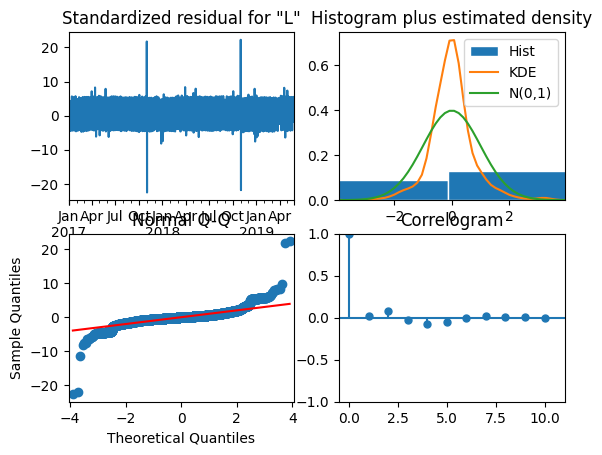

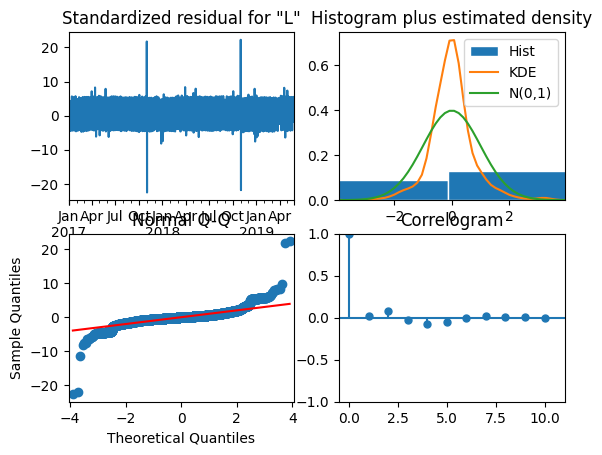

In [85]:
res.plot_diagnostics()

## Evaluation Metrics

[Clearly specify which metrics you'll use to evaluate the model performance, and why you've chosen these metrics.]


In [86]:
df_result = res.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)

In [87]:
df_result

2019-05-26 23:00:00+00:00    161812.444844
2019-05-27 00:00:00+00:00    191466.251220
2019-05-27 01:00:00+00:00    195848.060229
2019-05-27 02:00:00+00:00    195974.449675
2019-05-27 03:00:00+00:00    201470.284941
                                 ...      
2019-12-31 18:00:00+00:00    277297.762993
2019-12-31 19:00:00+00:00    266033.762993
2019-12-31 20:00:00+00:00    254625.762993
2019-12-31 21:00:00+00:00    242145.762993
2019-12-31 22:00:00+00:00    228545.762993
Freq: H, Name: predicted_mean, Length: 5256, dtype: float64

<Axes: xlabel='Date (UTC)'>

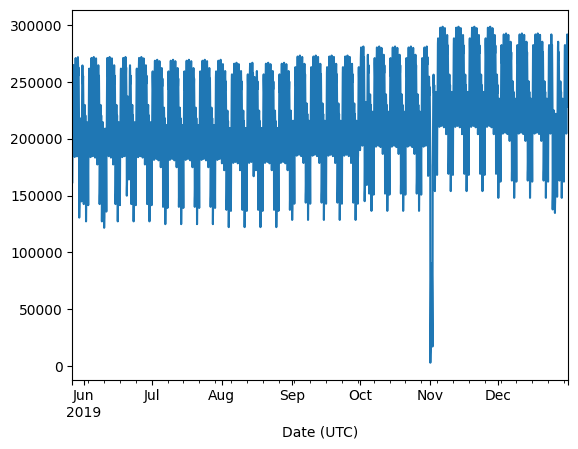

In [88]:
df_result.index = X_test.index
df_result.plot()

<Axes: xlabel='Date (UTC)'>

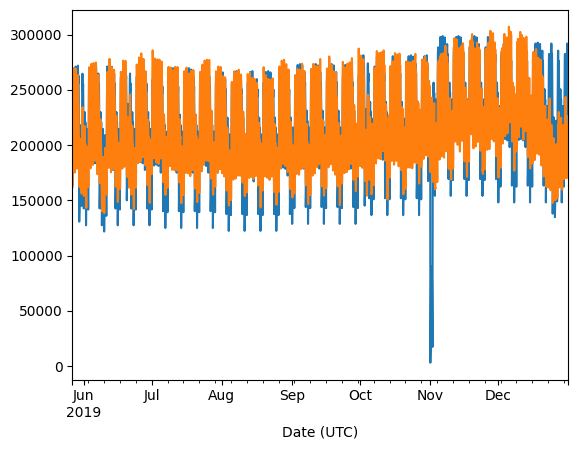

In [89]:
df_result.plot()
y_test.plot()

<Axes: xlabel='Date (UTC)'>

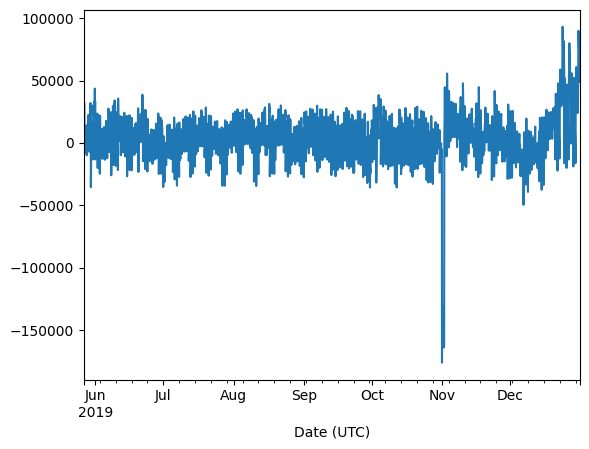

In [90]:
df_residuals = df_result - y_test
df_residuals.plot()

<Axes: xlabel='Date (UTC)'>

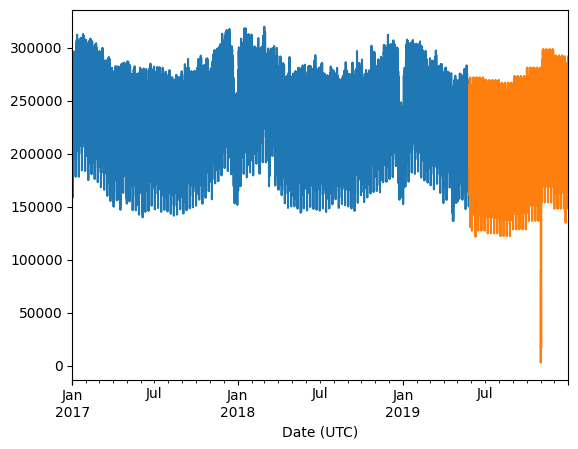

In [91]:
y_train.plot()
df_result.plot()

In [92]:
create_error_metrics(y_test, df_result)  # 101-000-24

,MAE,MSE,RMSE,MAPE %,R2 %
0,12926.55,3.780120e+08,19442.53,6.3,75.03


In [67]:
# create_error_metrics(y_test, df_result) # 000-000-00

,MAE,MSE,RMSE,MAPE %,R2 %
0,12929.81,3.779321e+08,19440.47,6.3,75.04


In [52]:
# create_error_metrics(y_test, df_result) # 001-000-00

,MAE,MSE,RMSE,MAPE %,R2 %
0,12925.75,3.777744e+08,19436.42,6.29,75.05


In [44]:
# create_error_metrics(y_test, df_result) # 202-202-24

,MAE,MSE,RMSE,MAPE %,R2 %
0,12944.16,3.784679e+08,19454.25,6.3,75.0


In [37]:
# create_error_metrics(y_test, df_result) # 101-101-24

,MAE,MSE,RMSE,MAPE %,R2 %
0,12946.48,3.785902e+08,19457.4,6.31,75.0


In [29]:
# create_error_metrics(y_test, df_result) # 101-100-24

,MAE,MSE,RMSE,MAPE %,R2 %
0,12946.33,3.785757e+08,19457.02,6.31,75.0


In [21]:
# create_error_metrics(y_test, df_result) # 101-000-24

,MAE,MSE,RMSE,MAPE %,R2 %
0,12926.55,3.780120e+08,19442.53,6.3,75.03


In [13]:
# create_error_metrics(y_test, df_result) # 111-101-24

,MAE,MSE,RMSE,MAPE %,R2 %
0,37700.4,2.160451e+09,46480.66,15.93,-42.69


In [14]:
# Evaluate the model using your chosen metrics
# Example for classification
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))

# Example for regression
# mse = mean_squared_error(y_test, y_pred)

# Your evaluation code here


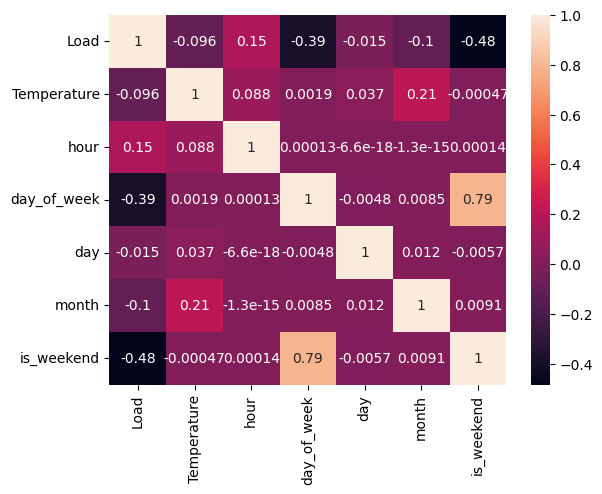

In [76]:
df_corr = get_energy_data()
german_holidays_corr = holidays.country_holidays("Germany", years=[2017, 2018, 2019],
                                                 subdiv="BY") + holidays.country_holidays("Germany",
                                                                                          years=[2017, 2018, 2019],
                                                                                          subdiv="SH")
df_corr['hour'] = df.index.hour
df_corr['day_of_week'] = df.index.dayofweek
df_corr['day'] = df.index.day
df_corr['month'] = df.index.month
# df_corr['day_of_year'] = df.index.dayofyear
df_corr['is_weekend'] = df.index.weekday // 5
# df_corr.loc[:, 'holiday'] = ["non-holiday" if x not in german_holidays_corr else german_holidays_corr.get(x) for x in df.index.date]

correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [15]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")


In [118]:
model_1 = sm.tsa.statespace.SARIMAX(
    y_train, X_train,
    order=(2, 0, 2), seasonal_order=(2, 0, 2, 24)
)
result_1 = model_1.fit()
print(result_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Load   No. Observations:                21024
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood             -216568.399
Date:                            Mon, 29 Jan 2024   AIC                         433276.798
Time:                                    22:52:34   BIC                         433833.538
Sample:                                12-31-2016   HQIC                        433458.506
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
hour_1                             7168.3250    443.566     16.161  

In [99]:
model_2 = sm.tsa.statespace.SARIMAX(
    y_train, X_train,
    order=(1, 0, 1), seasonal_order=(1, 0, 1, 24)
)
result_2 = model_2.fit()
print(result_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Load   No. Observations:                21024
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -216886.445
Date:                            Mon, 29 Jan 2024   AIC                         433904.890
Time:                                    22:29:52   BIC                         434429.816
Sample:                                12-31-2016   HQIC                        434076.215
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
hour_1                             7168.3250    425.630     16.842  

In [96]:
model_3 = sm.tsa.statespace.SARIMAX(
    y_train, X_train,
    order=(1, 0, 1), seasonal_order=(0, 0, 0, 24)
)
result_3 = model_3.fit()
print(result_3.summary())

                               SARIMAX Results                                
Dep. Variable:                   Load   No. Observations:                21024
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -217774.162
Date:                Mon, 29 Jan 2024   AIC                         435676.323
Time:                        22:18:13   BIC                         436185.342
Sample:                    12-31-2016   HQIC                        435842.456
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
hour_1                             7168.3250    246.371     29.096      0.000    6685.447    7651.203
hour_2                             1.043e+04    723.624     14

In [97]:
model_4 = sm.tsa.statespace.SARIMAX(
    y_train, X_train,
    order=(1, 1, 1), seasonal_order=(1, 0, 1, 24)
)
result_4 = model_4.fit()
print(result_4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Load   No. Observations:                21024
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -204560.735
Date:                            Mon, 29 Jan 2024   AIC                         409253.470
Time:                                    22:25:04   BIC                         409778.392
Sample:                                12-31-2016   HQIC                        409424.794
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
hour_1                            -1496.1990   1472.496     -1.016  

In [119]:
df_result_1 = result_1.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)
df_result_2 = result_2.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)
df_result_3 = result_3.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)
df_result_4 = result_4.predict(start=len(X_train), end=len(X_train) + len(X_test) - 1, exog=X_test)
df_result_1.index = X_test.index
df_result_2.index = X_test.index
df_result_3.index = X_test.index
df_result_4.index = X_test.index

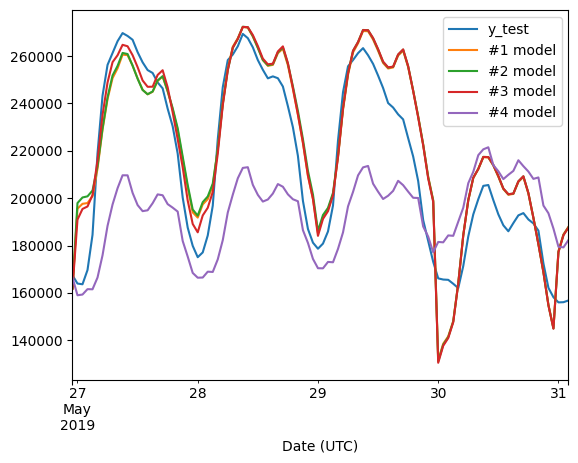

In [120]:
time_horizont = 100
ax = y_test.iloc[:time_horizont].plot()
df_result_1.iloc[:time_horizont].plot(ax=ax)
df_result_2.iloc[:time_horizont].plot(ax=ax)
df_result_3.iloc[:time_horizont].plot(ax=ax)
df_result_4.iloc[:time_horizont].plot(ax=ax)
ax.legend(["y_test", "#1 model", '#2 model', '#3 model', '#4 model']);